## Assumptions:
- Only analyse data belonging to the 2 above-mentioned cities and ROC/WG orders which experience the change of service fee.
- May 2023 data are excluded because it does not contain data for the whole month.
- Success can be defined in many ways. I define success if there is no statisically significant evidence that there is a change in the sales metric (defined by the average number of aggregated orders per pre-defined period for e.g. monthly or weekly). I will exclude daily sales because the variability is too large and may not be meaningful.
- Here I will propose the use of Hypothesis testing. The null hypothesis is that the average orders before service fee change == the average orders after service fee change. I will use significance level of 0.05 in this exercise. I intentionally choose to compare weekly sales as the monthly orders data have to little sample size (<30).

In [108]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from scipy import stats

In [76]:
# Read the raw file
raw_file = "Q1 Service Fee Change.csv"
df_raw = pd.read_csv(raw_file)

In [77]:
# Filter by the relevant cities
df_data = df_raw[(df_raw["city_name"] == "Miami, FL") | (df_raw["city_name"] == "San Francisco, CA") ]
# Remove rows without either ROC or WG orders
mask = df_data[["roc_orders", "wg_orders"]].isnull().all(axis=1)
# Filter the DataFrame using the mask
df_data = df_data[~mask]
# Fill null with 0 order
df_data[["roc_orders", "wg_orders"]] = df_data[["roc_orders", "wg_orders"]].fillna(0)

# Add new columns for analysis

def get_total_roc_wg_orders(row):
    return row["roc_orders"] + row["wg_orders"]

def get_month_year(row):
    return str(row["date"].month) + "_" + str(row["date"].year)

def week_of_month(date):
    first_day = date.replace(day=1)
    day_of_month = date.day
    adjust = (first_day.weekday() + 1) % 7
    weekday_of_first = first_day.weekday()
    
    if weekday_of_first == 6:
        num_weeks = (day_of_month + adjust) // 7
    else:
        num_weeks = (day_of_month + adjust) // 7 + 1
        
    return num_weeks

def get_week_month_year(row):
    return str(week_of_month(row["date"])) + "_" + str(row["date"].month) + "_" + str(row["date"].year)




df_data["total_roc_wg_orders"] = df_data.apply(get_total_roc_wg_orders, axis=1)
df_data['date'] = pd.to_datetime(df_data['date'])
df_data["month_year"] = df_data.apply(get_month_year, axis=1)
# exclude May 2023 data because it is not a full month data
df_data = df_data[df_data["month_year"] != "5_2023"]
df_data["week_month_year"] = df_data.apply(get_week_month_year, axis=1)

# print(df_data["week_month_year"].unique())

['1_3_2022' '2_3_2022' '3_3_2022' '4_3_2022' '5_3_2022' '1_4_2022'
 '2_4_2022' '3_4_2022' '4_4_2022' '5_4_2022' '6_4_2022' '0_5_2022'
 '1_5_2022' '2_5_2022' '3_5_2022' '4_5_2022' '1_6_2022' '2_6_2022'
 '3_6_2022' '4_6_2022' '5_6_2022' '1_7_2022' '2_7_2022' '3_7_2022'
 '4_7_2022' '5_7_2022' '6_7_2022' '1_8_2022' '2_8_2022' '3_8_2022'
 '4_8_2022' '5_8_2022' '1_9_2022' '2_9_2022' '3_9_2022' '4_9_2022'
 '5_9_2022' '2_10_2022' '3_10_2022' '4_10_2022' '5_10_2022' '6_10_2022'
 '1_11_2022' '2_11_2022' '3_11_2022' '4_11_2022' '5_11_2022' '1_12_2022'
 '2_12_2022' '3_12_2022' '4_12_2022' '5_12_2022' '6_12_2022' '0_1_2023'
 '1_1_2023' '2_1_2023' '3_1_2023' '4_1_2023' '1_2_2023' '2_2_2023'
 '3_2_2023' '4_2_2023' '5_2_2023' '1_3_2023' '2_3_2023' '3_3_2023'
 '4_3_2023' '5_3_2023' '2_4_2023' '3_4_2023' '4_4_2023' '5_4_2023'
 '6_4_2023']


In [78]:
# Filter before and after fee change
key_date = pd.Timestamp(2022, 9, 12, 0, 0, 0)

df_data_bf = df_data[df_data['date'] < key_date]
print(df_data_bf.shape)
df_data_af = df_data[df_data['date'] >= key_date]
print(df_data_af.shape)

(280, 10)
(305, 10)


# Define Common Analysis Function

In [ ]:
# Define a function to aggregate the order data by selected label (monthly, weekly, etc)
def compute_aggregate_orders_data(df, agg_label: str, order_type: str):
    agg_labels = df[agg_label].unique()
    agg_data = {}
    
    for elem in agg_labels:
        agg_data[elem] = {"Total" : 0, "Daily" : []}
        df_agg = df[df[agg_label] == elem]
        
        for idx, row in df_agg.iterrows():
            agg_data[elem]["Total"] += row[order_type]
            agg_data[elem]["Daily"].append(row[order_type])
            
    return agg_data

In [114]:
def plot_order_trend(orders_bf, orders_af, order_type, agg_label):
    
    # Plot the graph by monthly
    x_segments = []
    y_segments = []

    agg_labels = []
    agg_orders = []
    for key in orders_bf.keys():
        agg_labels.append(key)
        agg_orders.append(orders_bf[key]["Total"])

    x_segments.append(agg_labels)
    y_segments.append(agg_orders)    

    agg_labels = []
    agg_orders = []
    for key in orders_af.keys():
        agg_labels.append(key)
        agg_orders.append(orders_af[key]["Total"])

    x_segments.append(agg_labels)
    y_segments.append(agg_orders)  

    colors = ['red', 'blue']
    labels = ["Before Fee Change", "After Fee Change"]


    # Plotting the time series data
    plt.figure(figsize=(10, 6))

    for i in range(len(x_segments)):
        plt.plot(x_segments[i], y_segments[i], color=colors[i], label=labels[i])
    
    plt.xticks(fontsize=5)
    plt.xticks(rotation=45)
    plt.title(order_type + " Orders by " + agg_label)
    plt.xlabel(agg_label)
    plt.ylabel('No. of orders')

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

# Analyse by Individual Order Type (ROC and WG)

In [122]:
# Aggregate the order data by month
roc_monthly_orders_bf = compute_aggregate_orders_data(df_data_bf, "month_year", "roc_orders")
roc_monthly_orders_af = compute_aggregate_orders_data(df_data_af, "month_year", "roc_orders")
wg_monthly_orders_bf = compute_aggregate_orders_data(df_data_bf, "month_year", "wg_orders")
wg_monthly_orders_af = compute_aggregate_orders_data(df_data_af, "month_year", "wg_orders")

# Aggregate the order data by week
roc_weekly_orders_bf = compute_aggregate_orders_data(df_data_bf, "week_month_year", "roc_orders")
roc_weekly_orders_af = compute_aggregate_orders_data(df_data_af, "week_month_year", "roc_orders")    
wg_weekly_orders_bf = compute_aggregate_orders_data(df_data_bf, "week_month_year", "wg_orders")
wg_weekly_orders_af = compute_aggregate_orders_data(df_data_af, "week_month_year", "wg_orders") 

## Plot the data first to have overall visual understanding of the data

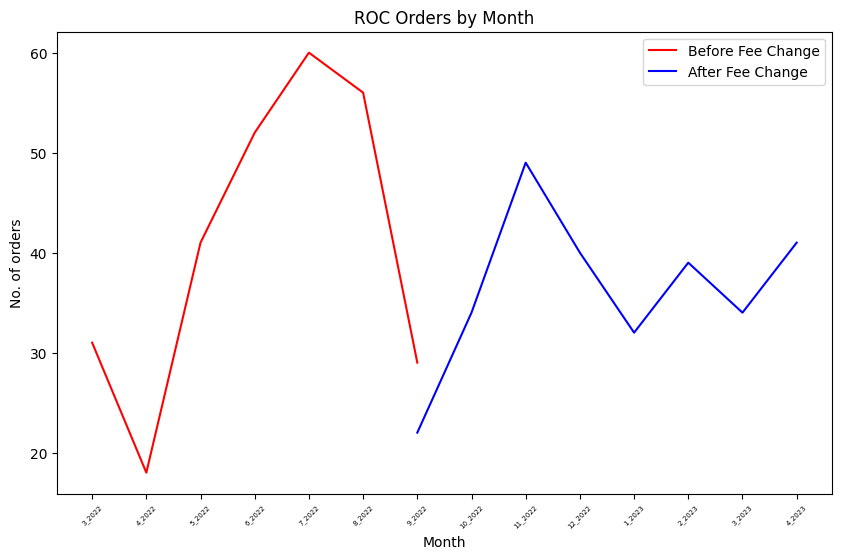

In [120]:
# Plot the monthly order data
plot_order_trend(roc_monthly_orders_bf, roc_monthly_orders_af, "ROC", "Month")

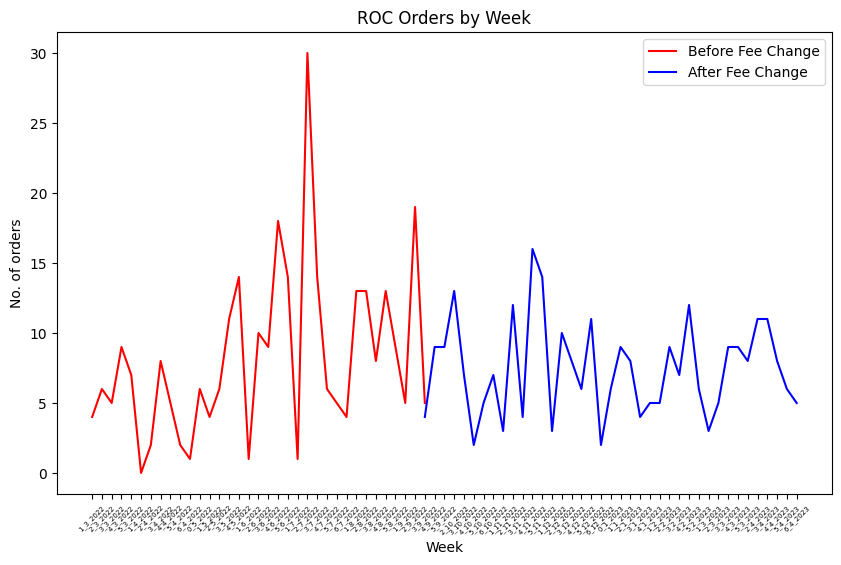

In [121]:
# Plot the weekly order data
plot_order_trend(roc_weekly_orders_bf, roc_weekly_orders_af, "ROC", "Week")

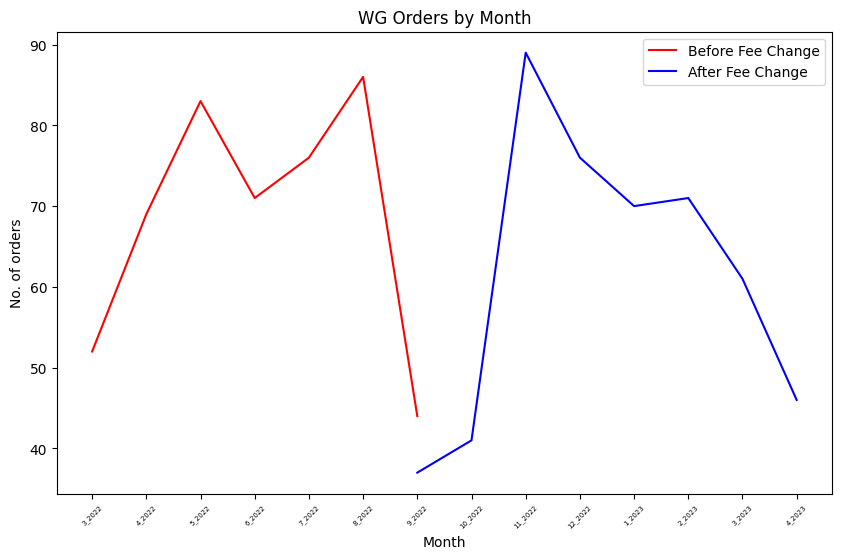

In [123]:
# Plot the monthly order data
plot_order_trend(wg_monthly_orders_bf, wg_monthly_orders_af, "WG", "Month")

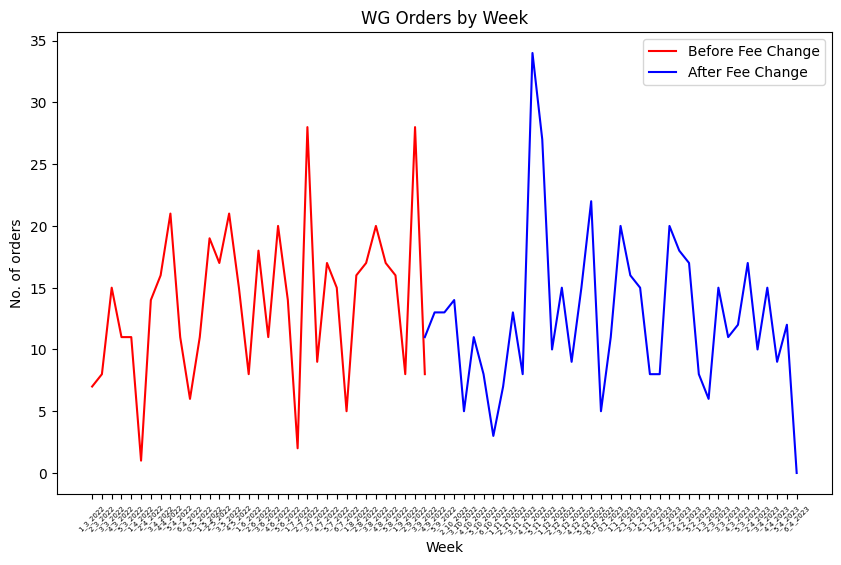

In [124]:
# Plot the weekly order data
plot_order_trend(wg_weekly_orders_bf, wg_weekly_orders_af, "WG", "Week")

## Perform hypothesis testing for weekly order data (ROC)

In [125]:
# Do hypothesis testing for weekly data
data_before = []
for key in roc_weekly_orders_bf.keys():
    data_before.append(roc_weekly_orders_bf[key]['Total'])
    
data_after = []
for key in roc_weekly_orders_af.keys():
    data_after.append(roc_weekly_orders_af[key]['Total'])
    

In [126]:
# Perform t-test
t_statistic, p_value = stats.ttest_ind(data_before, data_after)

# Interpret results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis - There is a significant difference between the groups.")
else:
    print("Fail to reject null hypothesis - There is no significant difference between the groups.")

Fail to reject null hypothesis - There is no significant difference between the groups.


## Perform hypothesis testing for weekly order data (WG)

In [130]:
# Do hypothesis testing for weekly data
data_before = []
for key in wg_weekly_orders_bf.keys():
    data_before.append(wg_weekly_orders_bf[key]['Total'])
    
data_after = []
for key in wg_weekly_orders_af.keys():
    data_after.append(wg_weekly_orders_af[key]['Total'])

In [131]:
# Perform t-test
t_statistic, p_value = stats.ttest_ind(data_before, data_after)

# Interpret results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis - There is a significant difference between the groups.")
else:
    print("Fail to reject null hypothesis - There is no significant difference between the groups.")

Fail to reject null hypothesis - There is no significant difference between the groups.


# Conclusion

## Mission 1

The service fee change is successful as there is no significant evidence that the average weekly ROC/WG orders have changed.

## Mission 2

For both ROG and WG orders, there seem to be a dip in order numbers in the month (9/2022) where the service fee changed. Possibly because many would have anticipated the change and therefore made the orders before the fee change.

## Mission 3

I assume that optimal service fees means to be one that causes increase in profit while at least maintaing the level of orders. There can be either qualitative or quantitative method to determine the number. Qualitatively, one can actually survey the market rate of such fees across different service providers to have a feel of what is reasonable and acceptable in the eyes of the customers. Another way would be to survey the current economic outlook of the country and adjust the pricing as a factor of inflation rate or other rate increase such as GST.

I am unable to give informed estimate on what is the final numbers especially I don't have contextual knowledge of the US market and what those services (ROG and WG) entail exactly. But I think a good gauge would be that it should not cost more than 10-15% of the total cost of items being bought.